In [1]:
# Install the quickdraw library for easy dataset access
!pip install quickdraw

# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# For downloading the dataset
from quickdraw import QuickDrawData

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
import os

# Go to root workspace (safe place to store data)
%cd /content

# Create a folder for data
os.makedirs("quickdraw_data", exist_ok=True)
%cd quickdraw_data


/content
/content/quickdraw_data


In [3]:
# ==========================================
# ✅ Step 2: Load and preprocess QuickDraw data
# ==========================================
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

# Go to workspace root
%cd /content

# Make folder for data
os.makedirs("quickdraw_data", exist_ok=True)
%cd quickdraw_data

# Choose classes (10 for now)
class_names = [
    "cat", "dog", "car", "tree", "sun",
    "bicycle", "house", "star", "cloud", "apple"
]
print(f"Working with {len(class_names)} classes: {class_names}")

# Download 10 bitmap files (.npy) directly from Google Cloud Storage
base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
for name in class_names:
    fname = name.replace(" ", "%20")
    local_file = f"{name}.npy"
    if not os.path.exists(local_file):
        print(f"Downloading {name}...")
        os.system(f"wget -q {base_url}{fname}.npy -O '{local_file}'")

%cd /content

# Load and preprocess
def load_quickdraw(classes, samples_per_class=20000):
    X, y = [], []
    for idx, c in enumerate(classes):
        path = f"quickdraw_data/{c}.npy"
        data = np.load(path)
        data = data[:samples_per_class]              # 20k per class
        X.append(data)
        y.append(np.full(data.shape[0], idx))
    X = np.concatenate(X)
    y = np.concatenate(y)
    X = X.reshape(-1, 28, 28, 1).astype("float32") / 255.0  # normalize 0–1
    return X, y

X, y = load_quickdraw(class_names)

print(f"Loaded dataset: X={X.shape}, y={y.shape}")

# Split into train/validation/test sets (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


/content
/content/quickdraw_data
Working with 10 classes: ['cat', 'dog', 'car', 'tree', 'sun', 'bicycle', 'house', 'star', 'cloud', 'apple']
/content
Loaded dataset: X=(200000, 28, 28, 1), y=(200000,)
Train: (160000, 28, 28, 1) Val: (20000, 28, 28, 1) Test: (20000, 28, 28, 1)


In [4]:
!ls

quickdraw_data	sample_data


In [5]:
# Split data into training (80%) and a temporary set (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split the temporary set into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 160000
Validation set size: 20000
Test set size: 20000


In [7]:
# Binarize the pixel data as mentioned in the paper [cite: 45]
# We'll use a threshold of 0.5; pixels > 0.5 become 1, else 0.
X_train_bin = (X_train > 0.5).astype(np.float32)
X_val_bin = (X_val > 0.5).astype(np.float32)
X_test_bin = (X_test > 0.5).astype(np.float32)

# Reshape data for classical ML models (flatten the 28x28 images)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_train_bin_flat = X_train_bin.reshape(X_train_bin.shape[0], -1)
X_val_bin_flat = X_val_bin.reshape(X_val_bin.shape[0], -1)

# Reshape data for CNNs (add a channel dimension)
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]
X_train_bin_cnn = X_train_bin[..., np.newaxis]
X_val_bin_cnn = X_val_bin[..., np.newaxis]
X_test_bin_cnn = X_test_bin[..., np.newaxis]

# One-hot encode labels for deep learning models
num_classes = len(class_names) # Define num_classes here
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_val_cat = keras.utils.to_categorical(y_val, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

print("Data successfully reshaped and prepared for all models.")
print(f"Shape for classical models (e.g., Logistic Regression): {X_train_flat.shape}")
print(f"Shape for CNNs: {X_train_cnn.shape}")

Data successfully reshaped and prepared for all models.
Shape for classical models (e.g., Logistic Regression): (160000, 784)
Shape for CNNs: (160000, 28, 28, 1, 1)


In [8]:
print("--- Training Logistic Regression ---")

# Initialize the model with parameters from the paper
log_reg = LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=100,  # As specified in the paper [cite: 132]
    random_state=42,
    verbose=1
)

# Measure training time
start_time = time.time()
log_reg.fit(X_train_flat, y_train)
end_time = time.time()
training_time = end_time - start_time

# Evaluate on the validation set
y_pred_val = log_reg.predict(X_val_flat)
accuracy = accuracy_score(y_val, y_pred_val)

print("\n--- Logistic Regression Results ---")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Training Time: {training_time:.2f} seconds")

--- Training Logistic Regression ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- Logistic Regression Results ---
Validation Accuracy: 77.88%
Training Time: 97.93 seconds


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


In [9]:
# The paper used non-binarized data and normalized inputs for SVMs
# Our data is already normalized between [0, 1].

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
svm_results = {}

for kernel in kernels:
    print(f"--- Training SVM with {kernel.upper()} Kernel ---")

    # Initialize SVM
    # Note: Training SVM on this much data can be very slow.
    # We will use a smaller subset for a quick demonstration.
    # For a full reproduction, run this on the entire training set.
    subset_size = 10000
    X_train_svm_subset = X_train_flat[:subset_size]
    y_train_svm_subset = y_train[:subset_size]

    svm_model = SVC(kernel=kernel, random_state=42, gamma='scale')

    # Measure training time
    start_time = time.time()
    svm_model.fit(X_train_svm_subset, y_train_svm_subset)
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate on the validation set
    y_pred_svm = svm_model.predict(X_val_flat)
    accuracy = accuracy_score(y_val, y_pred_svm)

    svm_results[kernel] = {'accuracy': accuracy, 'time': training_time}

    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Training Time: {training_time:.2f} seconds\n")

print("\n--- SVM Results Summary ---")
for kernel, result in svm_results.items():
    print(f"Kernel: {kernel.upper()}, Accuracy: {result['accuracy']*100:.2f}%, Time: {result['time']:.2f}s")

--- Training SVM with LINEAR Kernel ---
Validation Accuracy: 69.08%
Training Time: 26.42 seconds

--- Training SVM with RBF Kernel ---
Validation Accuracy: 83.75%
Training Time: 26.49 seconds

--- Training SVM with POLY Kernel ---
Validation Accuracy: 84.10%
Training Time: 32.74 seconds

--- Training SVM with SIGMOID Kernel ---
Validation Accuracy: 69.19%
Training Time: 23.25 seconds


--- SVM Results Summary ---
Kernel: LINEAR, Accuracy: 69.08%, Time: 26.42s
Kernel: RBF, Accuracy: 83.75%, Time: 26.49s
Kernel: POLY, Accuracy: 84.10%, Time: 32.74s
Kernel: SIGMOID, Accuracy: 69.19%, Time: 23.25s


In [11]:
def create_cnn_v1(input_shape, num_classes):
    # V1: Full CNN as per Figure 2 [cite: 73]
    # Conv -> MaxPool -> Conv -> MaxPool -> Flatten -> Dense(128) -> Dense(Softmax)
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"), # Dense layer with 128 units [cite: 66]
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

def create_cnn_v2(input_shape, num_classes):
    # V2: Remove the second Convolutional Layer (and its Max Pool) [cite: 88]
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

def create_cnn_v3(input_shape, num_classes):
    # V3: Remove the second Max Pool Layer [cite: 87]
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        # No second max pool layer
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

def create_cnn_v4(input_shape, num_classes):
    # V4: Decrease number of dense units from 128 to 64 [cite: 79]
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"), # Dense units reduced to 64
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

print("CNN model creation functions are defined.")

CNN model creation functions are defined.


In [13]:
# Parameters for training
epochs = 20 # The paper ran for 100 iterations/epochs, but 20 is sufficient for a good result
batch_size = 128
input_shape = X_train_cnn.shape[1:-1] # Remove the extra dimension

# Create and compile the best model, V2
cnn_v2 = create_cnn_v2(input_shape, num_classes)
cnn_v2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn_v2.summary()

print("\n--- Training CNN V2 on Non-Binarized Data ---")
start_time = time.time()
history = cnn_v2.fit(
    X_train_cnn, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_cnn, y_val_cat)
)
end_time = time.time()
cnn_training_time = end_time - start_time

# Evaluate final performance on the test set
test_loss, test_acc = cnn_v2.evaluate(X_test_cnn, y_test_cat, verbose=2)

print("\n--- CNN V2 Results ---")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Training Time: {cnn_training_time:.2f} seconds")

# Plot training history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.title("CNN V2 Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)


--- Training CNN V2 on Non-Binarized Data ---
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 66ms/step - accuracy: 0.8301 - loss: 0.5565 - val_accuracy: 0.9104 - val_loss: 0.2922
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 138s 63ms/step - accuracy: 0.9203 - loss: 0.2566 - val_accuracy: 0.9252 - val_loss: 0.2410
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 64ms/step - accuracy: 0.9374 - loss: 0.1981 - val_accuracy: 0.9270 - val_loss: 0.2333
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 63ms/step - accuracy: 0.9460 - loss: 0.1710 - val_accuracy: 0.9288 - val_loss: 0.2260
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 85s 65ms/step - accuracy: 0.9558 - loss: 0.1362 - val_accuracy: 0.9313 - val_loss: 0.2189
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 63ms/step - accuracy: 0.9644 - loss: 0.1096 - val_accuracy: 0.9322 - val_loss: 0.2331
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 64ms/step - accuracy: 0.9724 - loss: 0.0861 - val_accuracy: 0.9296 - val_loss: 0.2489
Epoch 8/20
1250/1250 ━━━━━━━

NameError: name 'pd' is not defined

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step


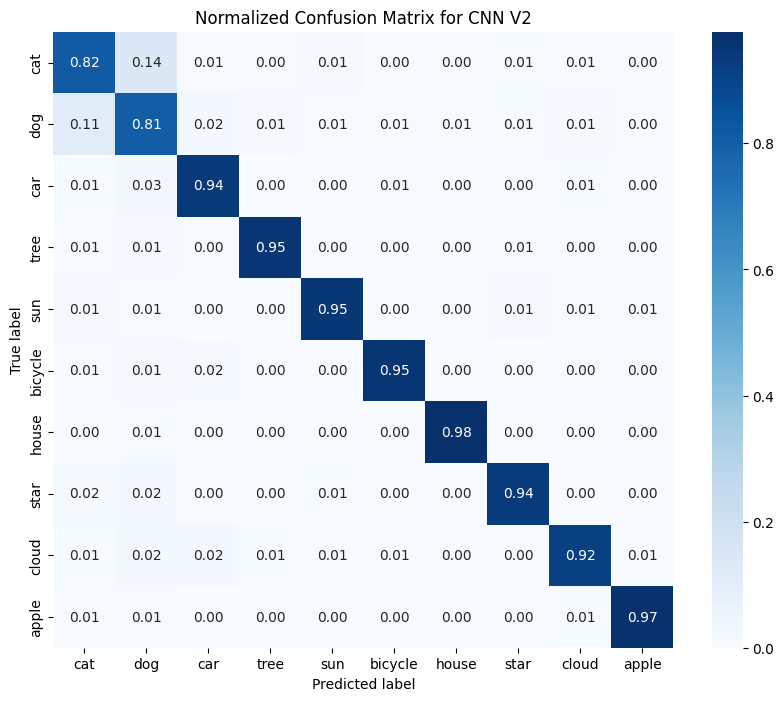

In [14]:
# Generate predictions on the test set
y_pred_cnn = cnn_v2.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix for CNN V2")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()